# Compare MNDWI result between Landsat and Sentinal-2 data

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr), 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

In [2]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import geopandas as gpd
import xarray as xr
from sklearn.metrics import mean_absolute_error
from scipy import stats
from scipy.stats import gaussian_kde
from deafrica_tools.plotting import display_map, rgb, map_shapefile
%matplotlib inline

import os
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [5]:
client = create_local_dask_cluster(return_client=True)

Client Scheduler: tcp://127.0.0.1:42531 Dashboard: /user/zlin@frontiersi.com.au/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 12.03 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [7]:
dc = datacube.Datacube(app="Coastal_erosion")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2013', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Landsat 8 and 9 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.

In [39]:
# Define the area of interest
lat = -34.171230
lon = 24.522350
buffer = 0.02

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)


# Set the range of dates for the analysis, time step and tide range
time_range = ('2021', '2022')
time_step = '1Y'
tide_range = (0.3, 0.7)


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [40]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Landsat and Sentinel-2 data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 8 and 9 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [41]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query_land = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir_1'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query_land)

# Load available data Landsat 8
landsat_ds = load_ard(dc=dc, 
                      products=['ls8_sr', 
                                'ls9_sr'
                               ], 
                      output_crs=output_crs,
                      resampling='bilinear',
                      #align=(15, 15),
                      mask_filters=[("opening", 2), ("dilation", 5)],
                      dask_chunks={'time': 1},
                      group_by='solar_day',
                      **query_land)


query_sen = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir_1'],
    'resolution': (-10, 10),
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query_sen)

# Load available data
sentinel_ds = load_ard(dc=dc,
              products=['s2_l2a'],
              output_crs=output_crs,
              resampling='bilinear',
              #align=(5, 5),
              mask_filters=[("opening", 2), ("dilation", 5)],
              dask_chunks={'time': 1},
              group_by='solar_day',
              **query_sen)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 66 time steps as a dask array
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 144 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [42]:
print(landsat_ds)
print(sentinel_ds)

<xarray.Dataset>
Dimensions:      (time: 66, y: 151, x: 128)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-26T08:11:02.525242 ... 2022-12...
  * y            (y) float64 -3.782e+06 -3.782e+06 ... -3.786e+06 -3.786e+06
  * x            (x) float64 2.697e+05 2.697e+05 ... 2.735e+05 2.735e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref
<xarray.Dataset>
Dimensions:      (time: 144, y: 453, x: 381)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-04T08:29:42 ... 2022-12-30T08:...
  * y            (y) float64 6.218e+06 6.218e+06 ... 6.21

### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


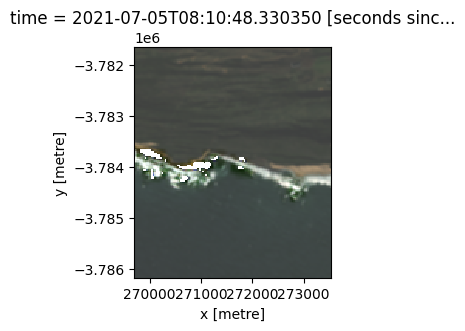

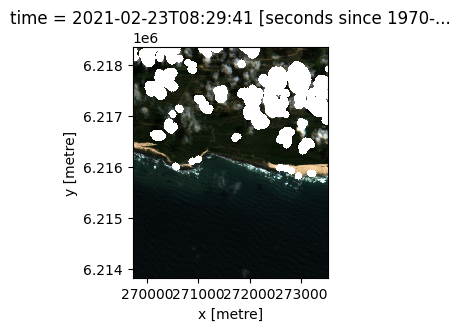

In [44]:
# Set the timesteps to visualise
timestep = 10


# Generate RGB plots at each timestep

rgb(landsat_ds, index=timestep, percentile_stretch=[0, 0.999],size=3)
rgb(sentinel_ds, index=timestep, percentile_stretch=[0, 0.999],size=3)

## Use tide to fliter two dataset

In [45]:
# Calculate tides for each timestep in the satellite dataset
landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)
sentinel_ds = tidal_tag(ds=sentinel_ds, tidepost_lat=None, tidepost_lon=None)

# Calculate the min and max tide heights to include based on the % range
min_tide_land, max_tide_land = landsat_ds.tide_height.quantile(tide_range) 
min_tide_sen, max_tide_sen = sentinel_ds.tide_height.quantile(tide_range) 

# Keep timesteps larger than the min tide, and smaller than the max tide
landsat_flit_ds = landsat_ds.sel(time=(landsat_ds.tide_height > min_tide_land) & (landsat_ds.tide_height <= max_tide_land))
sentinel_flit_ds = sentinel_ds.sel(time=(sentinel_ds.tide_height > min_tide_sen) & (sentinel_ds.tide_height <= max_tide_sen))


Setting tide modelling location from dataset centroid: 24.52, -34.17
Setting tide modelling location from dataset centroid: 24.52, -34.17


## Use DEA Shorelines product to fliter the area that users want to compare

In [46]:
from deafrica_tools.coastal import get_coastlines
from shapely.geometry import LineString

# set the buffer area 
xmin, xmax = lon - buffer, lon + buffer
ymin, ymax = lat - buffer, lat + buffer
bbox = (xmin, ymin, xmax, ymax)

# Load DE Africa Coastlines annual shorelines data. 
deacl_shorelines_gdf = get_coastlines(bbox=bbox, layer='shorelines')

deacl_shorelines_gdf


buffered_shorelines_gdf = deacl_shorelines_gdf[(deacl_shorelines_gdf['year'] == "2020") & (deacl_shorelines_gdf['certainty'] == "good")].copy()
buffered_shorelines_gdf


shoreline_buf_dis = 0.01
buffered_shorelines_gdf['geometry'] = buffered_shorelines_gdf['geometry'].buffer(shoreline_buf_dis)


#print(buffered_shorelines_gdf)

# Plot on interactive map of DE Africa Coastlines data within our bounding box.
buffered_shorelines_gdf.explore(column='year', cmap='inferno', categorical=True)


In [47]:
# Use the buffer polygon to clip two raster dataset 

import rioxarray as rxr
from deafrica_tools.spatial import xr_vectorize, xr_rasterize

#Rasterise the area of interest polygon
shoreline_buffer_raster_landsat = xr_rasterize(gdf = buffered_shorelines_gdf,da = landsat_flit_ds, transform=landsat_flit_ds.geobox.transform, crs=landsat_ds.crs)
shoreline_buffer_raster_sentinel = xr_rasterize(gdf = buffered_shorelines_gdf,da = sentinel_flit_ds, transform=sentinel_flit_ds.geobox.transform, crs=sentinel_ds.crs)


#Mask the dataset to the rasterised area of interest
sentinel_clip_ds = sentinel_flit_ds.where(shoreline_buffer_raster_sentinel==1)
landsat_clip_ds = landsat_flit_ds.where(shoreline_buffer_raster_landsat==1)  


print(landsat_clip_ds)
print(sentinel_clip_ds)

#rgb(landsat_clip_ds, index=19, percentile_stretch=[0, 0.999])
#rgb(sentinel_clip_ds, index=19, percentile_stretch=[0, 0.999])


<xarray.Dataset>
Dimensions:      (time: 26, y: 151, x: 128)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-26T08:11:02.525242 ... 2022-12...
  * y            (y) float64 -3.782e+06 -3.782e+06 ... -3.786e+06 -3.786e+06
  * x            (x) float64 2.697e+05 2.697e+05 ... 2.735e+05 2.735e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 151, 128), meta=np.ndarray>
    tide_height  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref
<xarray.Dataset>
Dimensions:      (time: 58, y: 453, x: 381)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-04T08:29:42 ..

       spatial_ref  MNDWI         x          y
0            32635    NaN  269715.0 -3781665.0
1            32635    NaN  269745.0 -3781665.0
2            32635    NaN  269775.0 -3781665.0
3            32635    NaN  269805.0 -3781665.0
4            32635    NaN  269835.0 -3781665.0
...            ...    ...       ...        ...
19323        32635    NaN  273405.0 -3786165.0
19324        32635    NaN  273435.0 -3786165.0
19325        32635    NaN  273465.0 -3786165.0
19326        32635    NaN  273495.0 -3786165.0
19327        32635    NaN  273525.0 -3786165.0

[19328 rows x 4 columns]
        spatial_ref  MNDWI         x          y
0             32735    NaN  269725.0  6218345.0
1             32735    NaN  269735.0  6218345.0
2             32735    NaN  269745.0  6218345.0
3             32735    NaN  269755.0  6218345.0
4             32735    NaN  269765.0  6218345.0
...             ...    ...       ...        ...
172588        32735    NaN  273485.0  6213825.0
172589        32735    NaN

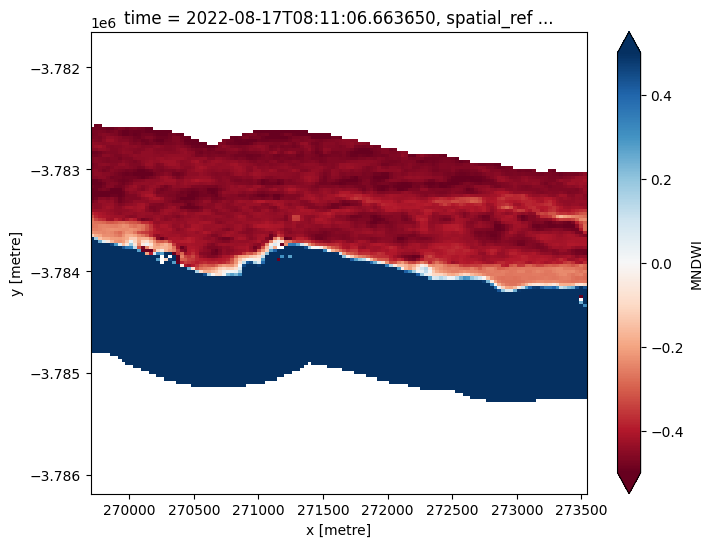

In [49]:
# Calculate the water index
landsat_clip_ds = calculate_indices(ds = landsat_clip_ds, index='MNDWI', satellite_mission='ls')
sentinel_clip_ds = calculate_indices(ds = sentinel_clip_ds, index='MNDWI', satellite_mission='s2')

average_mndwi_land = landsat_clip_ds['MNDWI'].mean(dim='time', skipna = True)
average_mndwi_values_land = average_mndwi_land.values
average_mndwi_sen = sentinel_clip_ds['MNDWI'].mean(dim='time', skipna = True)
average_mndwi_values_sen = average_mndwi_sen.values


average_mndwi_df_land = average_mndwi_land.to_dataframe()
average_mndwi_df_sen = average_mndwi_sen.to_dataframe()

average_mndwi_df_land['x'] = average_mndwi_df_land.index.get_level_values(1)
average_mndwi_df_land['y'] = average_mndwi_df_land.index.get_level_values(0)
average_mndwi_df_sen['x'] = average_mndwi_df_sen.index.get_level_values(1)
average_mndwi_df_sen['y'] = average_mndwi_df_sen.index.get_level_values(0)

average_mndwi_df_land.reset_index(drop=True, inplace=True)
average_mndwi_df_sen.reset_index(drop=True, inplace=True)

print(average_mndwi_df_land)
print(average_mndwi_df_sen)

# Save the average MNDWI result
average_mndwi_df_land.to_csv('average_mndwi_landsat_6.csv', index=False)
average_mndwi_df_sen.to_csv('average_mndwi_sentinel_6.csv', index=False)

#Using specific time
#landsat_df = landsat_ds.MNDWI.isel(time=timestep).to_dataframe().reset_index()
#landsat_df.to_csv('average_mndwi_landsat_x.csv', index=False)


# Plot the resulting image for the specific timestep
landsat_clip_ds.MNDWI.isel(time=19).plot(cmap='RdBu',
                                         size=6,
                                         vmin=-0.5,
                                         vmax=0.5)
plt.show()

## Start to do the comparison

In [63]:
# set path
MNDWIpath_land = 'average_mndwi_landsat_6.csv' 
MNDWIpath_sen = 'average_mndwi_sentinel_6.csv'

In [64]:
# read data
gdf_land = gpd.read_file(MNDWIpath_land)
gdf_sen = gpd.read_file(MNDWIpath_sen)

In [65]:
# check crs of two data
SenCrs = gdf_sen.loc[0, 'spatial_ref']
landCrs = gdf_land.loc[0, 'spatial_ref']
print('Sentinal-2 cooridinate system epsg: '+SenCrs)
print('Landsat cooridinate system epsg: '+landCrs)

Sentinal-2 cooridinate system epsg: 32735
Landsat cooridinate system epsg: 32635


In [66]:
# create landsat GeoDataFrame
from shapely.geometry import Point

# creates a new point object for futher 
gdf_land = gpd.GeoDataFrame( gdf_land ,geometry=gpd.points_from_xy(gdf_land.x, gdf_land.y))
gdf_land['lon'] = gdf_land.geometry.apply(lambda p: p.x)
gdf_land['lat'] = gdf_land.geometry.apply(lambda p: p.y)

# set the GeoDataFrame coordinate system
gdf_land = gdf_land.set_crs(epsg=landCrs)
print(gdf_land.crs)
gdf_land

epsg:32635


,spatial_ref,MNDWI,x,y,geometry,lon,lat
0,32635,,269715.0,-3781665.0,POINT (269715.000 -3781665.000),269715.0,-3781665.0
1,32635,,269745.0,-3781665.0,POINT (269745.000 -3781665.000),269745.0,-3781665.0
2,32635,,269775.0,-3781665.0,POINT (269775.000 -3781665.000),269775.0,-3781665.0
3,32635,,269805.0,-3781665.0,POINT (269805.000 -3781665.000),269805.0,-3781665.0
4,32635,,269835.0,-3781665.0,POINT (269835.000 -3781665.000),269835.0,-3781665.0
...,...,...,...,...,...,...,...
19323,32635,,273405.0,-3786165.0,POINT (273405.000 -3786165.000),273405.0,-3786165.0
19324,32635,,273435.0,-3786165.0,POINT (273435.000 -3786165.000),273435.0,-3786165.0
19325,32635,,273465.0,-3786165.0,POINT (273465.000 -3786165.000),273465.0,-3786165.0
19326,32635,,273495.0,-3786165.0,POINT (273495.000 -3786165.000),273495.0,-3786165.0


In [67]:
# convert Landsat coordinate system to the same of Sentinel coordinate system
gdf_land_toSenCrs = gdf_land.to_crs(epsg=SenCrs)
gdf_land_toSenCrs['lon'] = gdf_land_toSenCrs.geometry.apply(lambda p: p.x)
gdf_land_toSenCrs['lat'] = gdf_land_toSenCrs.geometry.apply(lambda p: p.y)

# change the X, Y value into integer 
gdf_land_toSenCrs.lon = gdf_land_toSenCrs.lon.round().astype(int)
gdf_land_toSenCrs.lat = gdf_land_toSenCrs.lat.round().astype(int)

# create a new column for corresponding the landsat and sentinel GeoDataFrame
gdf_land_toSenCrs = gdf_land_toSenCrs.assign(lon_lat=gdf_land_toSenCrs['lon'].astype(str) + '&' + gdf_land_toSenCrs['lat'].astype(str))
print(gdf_land_toSenCrs.crs)

#gdf_land_toSenCrs.to_csv("landsat0411.csv")
gdf_land_toSenCrs

epsg:32735


,spatial_ref,MNDWI,x,y,geometry,lon,lat,lon_lat
0,32635,,269715.0,-3781665.0,POINT (269715.000 6218335.000),269715,6218335,269715&6218335
1,32635,,269745.0,-3781665.0,POINT (269745.000 6218335.000),269745,6218335,269745&6218335
2,32635,,269775.0,-3781665.0,POINT (269775.000 6218335.000),269775,6218335,269775&6218335
3,32635,,269805.0,-3781665.0,POINT (269805.000 6218335.000),269805,6218335,269805&6218335
4,32635,,269835.0,-3781665.0,POINT (269835.000 6218335.000),269835,6218335,269835&6218335
...,...,...,...,...,...,...,...,...
19323,32635,,273405.0,-3786165.0,POINT (273405.000 6213835.000),273405,6213835,273405&6213835
19324,32635,,273435.0,-3786165.0,POINT (273435.000 6213835.000),273435,6213835,273435&6213835
19325,32635,,273465.0,-3786165.0,POINT (273465.000 6213835.000),273465,6213835,273465&6213835
19326,32635,,273495.0,-3786165.0,POINT (273495.000 6213835.000),273495,6213835,273495&6213835


In [68]:
# create Sentinal-2 GeoDataFrame
gdf_sen = gpd.GeoDataFrame( gdf_sen ,geometry=gpd.points_from_xy(gdf_sen.x, gdf_sen.y))
gdf_sen = gdf_sen.set_crs(epsg=SenCrs)

# creates a new point object
gdf_sen['lon'] = gdf_sen.geometry.apply(lambda p: p.x)
gdf_sen['lat'] = gdf_sen.geometry.apply(lambda p: p.y)

# change the X, Y value into integer 
gdf_sen.lon = gdf_sen.lon.round().astype(int)
gdf_sen.lat = gdf_sen.lat.round().astype(int)

# create a new column for corresponding the landsat and sentinel GeoDataFrame
gdf_sen = gdf_sen.assign(lon_lat=gdf_sen['lon'].astype(str) + '&' + gdf_sen['lat'].astype(str))
print(gdf_sen.crs)

#gdf_sen.to_csv("sentinel0411.csv")
gdf_sen

epsg:32735


,spatial_ref,MNDWI,x,y,geometry,lon,lat,lon_lat
0,32735,,269725.0,6218345.0,POINT (269725.000 6218345.000),269725,6218345,269725&6218345
1,32735,,269735.0,6218345.0,POINT (269735.000 6218345.000),269735,6218345,269735&6218345
2,32735,,269745.0,6218345.0,POINT (269745.000 6218345.000),269745,6218345,269745&6218345
3,32735,,269755.0,6218345.0,POINT (269755.000 6218345.000),269755,6218345,269755&6218345
4,32735,,269765.0,6218345.0,POINT (269765.000 6218345.000),269765,6218345,269765&6218345
...,...,...,...,...,...,...,...,...
172588,32735,,273485.0,6213825.0,POINT (273485.000 6213825.000),273485,6213825,273485&6213825
172589,32735,,273495.0,6213825.0,POINT (273495.000 6213825.000),273495,6213825,273495&6213825
172590,32735,,273505.0,6213825.0,POINT (273505.000 6213825.000),273505,6213825,273505&6213825
172591,32735,,273515.0,6213825.0,POINT (273515.000 6213825.000),273515,6213825,273515&6213825


In [69]:
# Usung inner join to merge two dataframe 
inner_join_gdf = pd.merge(gdf_land_toSenCrs, gdf_sen[['lon_lat', 'MNDWI']], on='lon_lat')

# rename the columns name 
inner_join_gdf = inner_join_gdf.rename(columns={'MNDWI_x': 'MNDWI_landsat'})
inner_join_gdf = inner_join_gdf.rename(columns={'MNDWI_y': 'MNDWI_sentinel'})

# convert the data into numeric 
inner_join_gdf['MNDWI_landsat'] = pd.to_numeric(inner_join_gdf['MNDWI_landsat'], errors='coerce')
inner_join_gdf['MNDWI_sentinel'] = pd.to_numeric(inner_join_gdf['MNDWI_sentinel'], errors='coerce')

#check the amount of NaN 
print(inner_join_gdf['MNDWI_landsat'].isna().sum())
print(inner_join_gdf['MNDWI_sentinel'].isna().sum())

#delete the row that contain NaN
inner_join_gdf.dropna(inplace=True)
#inner_join_gdf.to_csv("join0411.csv")
inner_join_gdf

9306
9306


,spatial_ref,MNDWI_landsat,x,y,geometry,lon,lat,lon_lat,MNDWI_sentinel
3810,32635,-0.469854,269745.0,-3782565.0,POINT (269745.000 6217435.000),269745,6217435,269745&6217435,-0.394866
3811,32635,-0.471084,269775.0,-3782565.0,POINT (269775.000 6217435.000),269775,6217435,269775&6217435,-0.385969
3937,32635,-0.462212,269745.0,-3782595.0,POINT (269745.000 6217405.000),269745,6217405,269745&6217405,-0.364665
3938,32635,-0.464831,269775.0,-3782595.0,POINT (269775.000 6217405.000),269775,6217405,269775&6217405,-0.392026
3939,32635,-0.466676,269805.0,-3782595.0,POINT (269805.000 6217405.000),269805,6217405,269805&6217405,-0.386085
...,...,...,...,...,...,...,...,...,...
15349,32635,0.762957,273015.0,-3785265.0,POINT (273015.000 6214735.000),273015,6214735,273015&6214735,0.612542
15350,32635,0.746007,273045.0,-3785265.0,POINT (273045.000 6214735.000),273045,6214735,273045&6214735,0.603854
15351,32635,0.762001,273075.0,-3785265.0,POINT (273075.000 6214735.000),273075,6214735,273075&6214735,0.598205
15352,32635,0.844680,273105.0,-3785265.0,POINT (273105.000 6214735.000),273105,6214735,273105&6214735,0.593711


In [70]:
# Visualise the comparison that only calculated data that have intersected.
x = inner_join_gdf['MNDWI_landsat']
y = inner_join_gdf['MNDWI_sentinel']

slope, intercept, r, p, sd = stats.linregress(x, y)
mae = mean_absolute_error(x,y)

In [71]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

linear eq: sentinel_MNDWI = 0.068*landsat_MNDWI + 0.078
MAE:  0.177




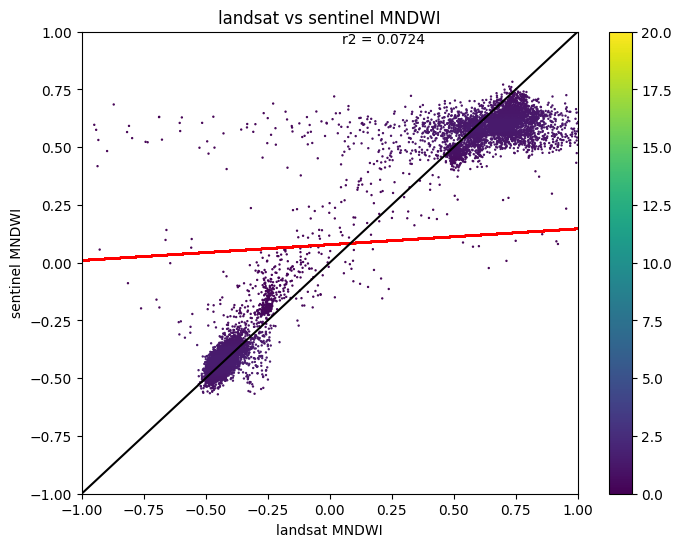

In [72]:
print(f'linear eq: sentinel_MNDWI = {slope:.3f}*landsat_MNDWI + {intercept:.3f}')
print("MAE: ", round(mae, 3))
print('\n')

fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, c=z, s=0.5)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.clim(0,20)
plt.colorbar()
plt.text(0.05,0.95,"r2 = "+str(round(r**2,4)))
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.plot([-1, 1], [-1, 1], 'k-')
ax.set_xlabel('landsat MNDWI')
ax.set_ylabel('sentinel MNDWI')
ax.set_title('landsat vs sentinel MNDWI');


In [73]:
# Using landsat point as the centroid to calculate the extent of grid

gdf_land_toSenCrs = gdf_land_toSenCrs.assign(lon_left = gdf_land_toSenCrs['lon'] -15, lon_right = gdf_land_toSenCrs['lon'] + 15, lat_top = gdf_land_toSenCrs['lat'] +15, lat_down = gdf_land_toSenCrs['lat'] - 15)

gdf_land_toSenCrs


,spatial_ref,MNDWI,x,y,geometry,lon,lat,lon_lat,lon_left,lon_right,lat_top,lat_down
0,32635,,269715.0,-3781665.0,POINT (269715.000 6218335.000),269715,6218335,269715&6218335,269700,269730,6218350,6218320
1,32635,,269745.0,-3781665.0,POINT (269745.000 6218335.000),269745,6218335,269745&6218335,269730,269760,6218350,6218320
2,32635,,269775.0,-3781665.0,POINT (269775.000 6218335.000),269775,6218335,269775&6218335,269760,269790,6218350,6218320
3,32635,,269805.0,-3781665.0,POINT (269805.000 6218335.000),269805,6218335,269805&6218335,269790,269820,6218350,6218320
4,32635,,269835.0,-3781665.0,POINT (269835.000 6218335.000),269835,6218335,269835&6218335,269820,269850,6218350,6218320
...,...,...,...,...,...,...,...,...,...,...,...,...
19323,32635,,273405.0,-3786165.0,POINT (273405.000 6213835.000),273405,6213835,273405&6213835,273390,273420,6213850,6213820
19324,32635,,273435.0,-3786165.0,POINT (273435.000 6213835.000),273435,6213835,273435&6213835,273420,273450,6213850,6213820
19325,32635,,273465.0,-3786165.0,POINT (273465.000 6213835.000),273465,6213835,273465&6213835,273450,273480,6213850,6213820
19326,32635,,273495.0,-3786165.0,POINT (273495.000 6213835.000),273495,6213835,273495&6213835,273480,273510,6213850,6213820


In [74]:
# create grid based on landsat data
from shapely.geometry import box

# check the value of the extent
xmin = gdf_land_toSenCrs['lon_left'].min()
xmax = gdf_land_toSenCrs['lon_right'].max()
ymax = gdf_land_toSenCrs['lat_top'].max()
ymin = gdf_land_toSenCrs['lat_down'].min()
print( xmin, xmax, ymax, ymin)

# create a 30*30 grid
cell_size = 30

grid_cells = []
for x0 in np.arange(xmin + cell_size, xmax, cell_size ):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# add a ID column for spatial join corresponding 
cell['ID'] = range(1, len(cell) + 1)

# set the coordinate system
cell = cell.set_crs(epsg=SenCrs)

print(cell)


269700 273540 6218350 6213820
                                                geometry     ID
0      POLYGON ((269700.000 6213820.000, 269700.000 6...      1
1      POLYGON ((269700.000 6213850.000, 269700.000 6...      2
2      POLYGON ((269700.000 6213880.000, 269700.000 6...      3
3      POLYGON ((269700.000 6213910.000, 269700.000 6...      4
4      POLYGON ((269700.000 6213940.000, 269700.000 6...      5
...                                                  ...    ...
19299  POLYGON ((273480.000 6218230.000, 273480.000 6...  19300
19300  POLYGON ((273480.000 6218260.000, 273480.000 6...  19301
19301  POLYGON ((273480.000 6218290.000, 273480.000 6...  19302
19302  POLYGON ((273480.000 6218320.000, 273480.000 6...  19303
19303  POLYGON ((273480.000 6218350.000, 273480.000 6...  19304

[19304 rows x 2 columns]


In [75]:
# Using the created grid to spatial join sentinel and landsat data 

# Calculate the all sentinel's MNDWI values in each grid
Sjoin_sen = cell.sjoin(gdf_sen)
Sjoin_sen['MNDWI'] = pd.to_numeric(Sjoin_sen['MNDWI'], errors='coerce')
grid_avg_values_sen = Sjoin_sen.groupby('ID')['MNDWI'].mean()
cell['MNDWI_sentinel'] = grid_avg_values_sen

# Calculate the all landsat's MNDWI values in each grid
Sjoin_land = cell.sjoin(gdf_land_toSenCrs)
Sjoin_land['MNDWI'] = pd.to_numeric(Sjoin_land['MNDWI'], errors='coerce')
grid_avg_values_land = Sjoin_land.groupby('ID')['MNDWI'].mean()
cell['MNDWI_landsat'] = grid_avg_values_land

#check the amount of NaN 
print(cell['MNDWI_landsat'].isna().sum())
print(cell['MNDWI_sentinel'].isna().sum())

#delete the row that contain NaN
cell.dropna(inplace=True)

# Drop unnecessary columns from cell
#cell = cell.drop(columns=['index_right'])

cell

9433
9315


,geometry,ID,MNDWI_sentinel,MNDWI_landsat
47,"POLYGON ((269700.000 6215230.000, 269700.000 6...",48,0.440252,0.495058
48,"POLYGON ((269700.000 6215260.000, 269700.000 6...",49,0.465360,0.490512
49,"POLYGON ((269700.000 6215290.000, 269700.000 6...",50,0.467740,0.499542
50,"POLYGON ((269700.000 6215320.000, 269700.000 6...",51,0.481466,0.511830
51,"POLYGON ((269700.000 6215350.000, 269700.000 6...",52,0.468826,0.516791
...,...,...,...,...
19253,"POLYGON ((273480.000 6216850.000, 273480.000 6...",19254,-0.466763,-0.412979
19254,"POLYGON ((273480.000 6216880.000, 273480.000 6...",19255,-0.421784,-0.395245
19255,"POLYGON ((273480.000 6216910.000, 273480.000 6...",19256,-0.440826,-0.383585
19256,"POLYGON ((273480.000 6216940.000, 273480.000 6...",19257,-0.452851,-0.396134


In [76]:
# Visualise the comparison of the average value in the grid

x = cell['MNDWI_landsat']
y = cell['MNDWI_sentinel']

slope, intercept, r, p, sd = stats.linregress(x, y)
mae = mean_absolute_error(x,y)

In [77]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

linear eq: sentinel_MNDWI = 0.068*landsat_MNDWI + 0.079
MAE:  0.173




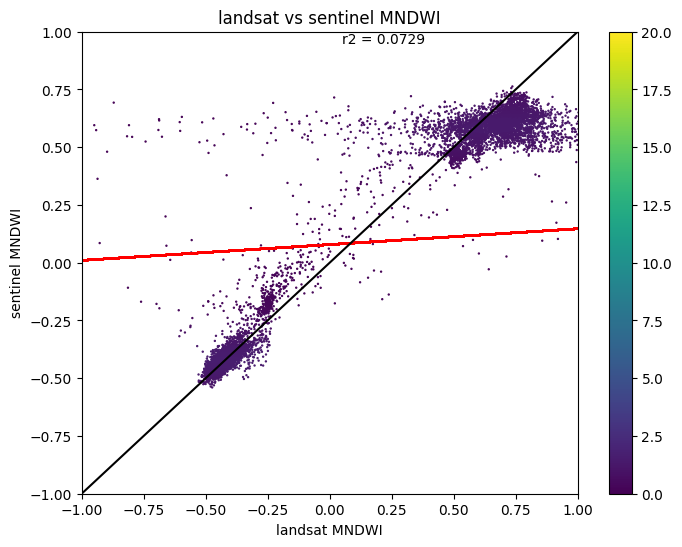

In [78]:
print(f'linear eq: sentinel_MNDWI = {slope:.3f}*landsat_MNDWI + {intercept:.3f}')
print("MAE: ", round(mae, 3))
print('\n')

fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, c=z, s=0.5)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.clim(0,20)
plt.colorbar()
plt.text(0.05,0.95,"r2 = "+str(round(r**2,4)))
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.plot([-1, 1], [-1, 1], 'k-')
ax.set_xlabel('landsat MNDWI')
ax.set_ylabel('sentinel MNDWI')
ax.set_title('landsat vs sentinel MNDWI');